In [1]:
%%capture

!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import unicodedata
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import fasttext
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv('Balanced_AHR.csv')

In [4]:
df = df[df['rating'] <= 2]      # Solo reseñas negativas

In [5]:
# Eliminar columnas innecesarias
df = df.drop(['label', 'hotel', 'location', 'rating', 'Unnamed: 0'], axis=1)

In [6]:
# Crear una columna que combine title y review
df['text'] = df['title'].astype(str)+'. '+df['review_text'].astype(str)

In [7]:
# Crear lista con cada oración (separada por .) por separado
lista_text = df['text'].tolist()

sentences = []

for line in lista_text:
    line = line.rstrip()
    oraciones = line.split('.')
    for oracion in oraciones:
        oracion = oracion.lstrip(' ')
        sentences.append(oracion)
sentences = list(filter(None, sentences))

In [8]:
# Convertir la lista anterior a dataframe
df_sentences = pd.DataFrame (sentences, columns = ['text'])

In [9]:
# Limpieza del texto
def preprocesar_columna(df):
    df['text'] = df['text'].str.strip().str.lower()
    caracteres = ['!', ',', '&', ':', ';', '(', ')', '.', '?', '"']
    for car in caracteres:
        df['text'] = df['text'].str.replace(car,'', regex=False)
    df['text'] = df['text'].str.normalize('NFKC')
    df['text'] = df['text'].str.replace(r'([a-zA-Z])\1{2,}', r'\1', regex=True) 
    return df

In [10]:
df_sentences = preprocesar_columna(df_sentences)

In [11]:
def normalize_str(text_string):
    if text_string is not None:
        result = unicodedata.normalize('NFD', text_string).encode('ascii', 'ignore').decode()
    else:
        result = None
    return result

In [12]:
df_sentences['text'] = df_sentences['text'].apply(normalize_str)

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/gitpod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
def eliminar_stopwords(text_string):
    stop_words = set(stopwords.words('spanish'))
    word_tokens = word_tokenize(text_string)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    sentence = ' '.join(str(x) for x in filtered_sentence)
    return sentence

In [16]:
df_sentences['text_sin_stopwords'] = df_sentences['text'].apply(eliminar_stopwords)

In [17]:
tfile = open('negativo2.txt', 'a')
tfile.write(df_sentences['text_sin_stopwords'].to_string())
tfile.close()

In [18]:
model = fasttext.train_unsupervised('negativo2.txt')

Read 0M words
Number of words:  2886
Number of labels: 0
Progress: 100.0% words/sec/thread:   24201 lr:  0.000000 avg.loss:  2.802449 ETA:   0h 0m 0s


In [19]:
df_sentences['vec'] = df_sentences['text_sin_stopwords'].apply(lambda x: model.get_sentence_vector(x))

In [20]:
df_sentences.sample(5)

,text,text_sin_stopwords,vec
15828,parecido a pension cutre,parecido pension cutre,"[-0.048666626, -0.060392477, -0.020304337, -0...."
5758,hemos llegado hoy y ha sido un fiasco,llegado hoy sido fiasco,"[-0.032700352, -0.06433633, -0.043482624, -0.0..."
16145,hasta ahi bien hasta q llegas a la habitacion,ahi bien q llegas habitacion,"[-0.07830923, -0.036561165, -0.012417956, -0.0..."
1752,no vuelvo ni gratis,vuelvo gratis,"[-0.06561425, -0.055594474, -0.022625236, -0.0..."
99,en definitiva nos fuimos al examen sin desayunar,definitiva examen desayunar,"[-0.06817016, -0.05056539, -0.026445527, -0.04..."


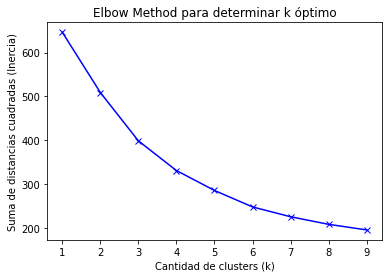

In [21]:
sum_distancias_cuadradas = []

K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_sentences['vec'].values.tolist())
    sum_distancias_cuadradas.append(kmeans.inertia_)

plt.plot(K, sum_distancias_cuadradas, 'bx-')
plt.xlabel('Cantidad de clusters (k)')
plt.ylabel('Suma de distancias cuadradas (Inercia)')
plt.title('Elbow Method para determinar k óptimo')
plt.show()

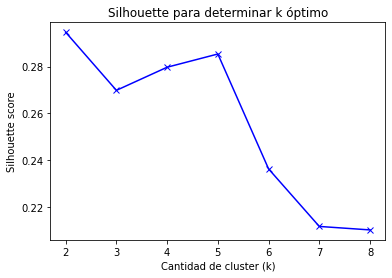

In [22]:
# Método para determinar la cantidad óptima de clusters

rango_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []

for num_clusters in rango_n_clusters:

    # fit Kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_sentences['vec'].values.tolist())
    cluster_labels = kmeans.labels_

    # calcular silhouette
    silhouette_avg.append(silhouette_score(df_sentences['vec'].values.tolist(), cluster_labels))

plt.plot(rango_n_clusters, silhouette_avg, 'bx-')    
plt.xlabel('Cantidad de cluster (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette para determinar k óptimo')
plt.show()

In [23]:
kmeans = KMeans(n_clusters=2)

In [24]:
df_sentences['cluster'] = kmeans.fit_predict(df_sentences['vec'].values.tolist())

In [25]:
cluster_0 = df_sentences[df_sentences['cluster']==0]
cluster_1 = df_sentences[df_sentences['cluster']==1]

In [26]:
def generate_wordcloud(df):
    text = ' '.join([i for i in df['text_sin_stopwords']])
    wordcloud = WordCloud(max_words=100, background_color='Black').generate(text)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

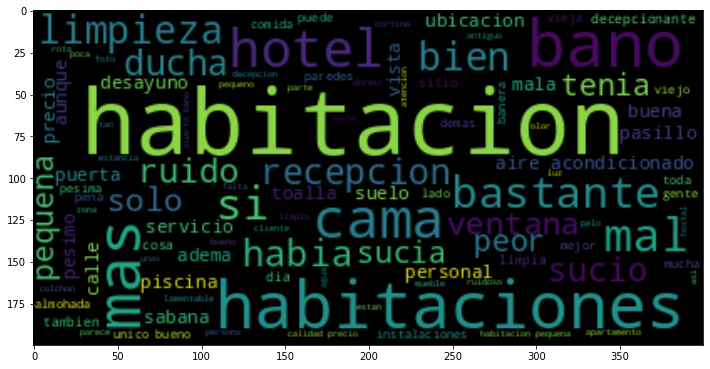

In [27]:
generate_wordcloud(cluster_0)

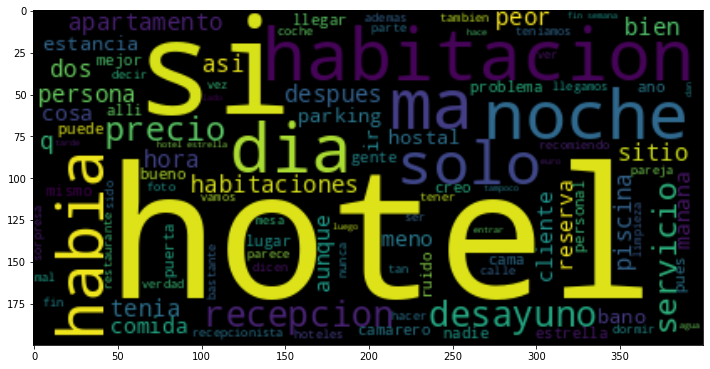

In [28]:
generate_wordcloud(cluster_1)

In [ ]:
# Hacer de nuevo los wordclouds pero sacando las palabras tipo hotel, más, etc.

# Ver cómo queda si se sacan las stopwords antes de clusterizar

# Hacer plot de los clusters

# Hacer resumen